In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
import pandas as pd
import numpy as np

adult = pd.read_csv("adult_with_pii.csv")
def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)
def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0


# The Exponential Mechanism

```{admonition} Learning Objectives
After reading this chapter, you will be able to:
- Define, implement, and apply the Exponential and Report Noisy Max mechanisms
- Describe the challenges of applying the Exponential mechanism in practice
- Describe the advantages of these mechanisms
```

The fundamental mechanisms we have seen so far (Laplace and Gaussian) are focused on numerical answers, and add noise directly to the answer itself. What if we want to return a precise answer (i.e. no added noise), but still preserve differential privacy? One solution is the exponential mechanism {cite}`mcsherry2007`, which allows selecting the "best" element from a set while preserving differential privacy. 

The analyst defines which element is the "best" by specifying a *scoring function* that outputs a score for each element in the set, and also defines the set of things to pick from. The mechanism provides differential privacy by *approximately* maximizing the score of the element it returns - in other words, to satisfy differential privacy, the exponential mechanism sometimes returns an element from the set which does *not* have the highest score.

```{prf:theorem} Exponential Mechanism 
:label: exponential-mechanism-def
The exponential mechanism satisfies $\epsilon$-differential privacy:

1. The analyst selects a set $\mathcal{R}$ of possible outputs
2. The analyst specifies a scoring function $u : \mathcal{D} \times \mathcal{R} \rightarrow \mathbb{R}$ with global sensitivity $\Delta u$
3. The exponential mechanism outputs $r \in \mathcal{R}$ with probability proportional to:

\begin{align}
\exp \Big(\frac{\epsilon u(x, r)}{2 \Delta u} \Big)
\end{align}
```

The biggest practical difference between the exponential mechanism and the previous mechanisms we've seen (e.g. the Laplace mechanism) is that the output of the exponential mechanism is *always* a member of the set $\mathcal{R}$. This is extremely useful when selecting an item from a finite set, when a noisy answer would not make sense. For example, we might want to pick a date for a big meeting, which uses each participant's personal calendar to maximize the number of participants without a conflict, while providing differential privacy for the calendars. Adding noise to a date doesn't make much sense: it might turn a Friday into a Saturday, and *increase* the number of conflicts significantly. The exponential mechanism is perfect for problems like this one: it selects a date *without noise*.

```{note}
The exponential mechanism is interesting for several reasons:

- The privacy cost of the mechanism is just $\epsilon$, regardless of the size of $\mathcal{R}$ - more on this next.
- It works for both finite and infinite sets $\mathcal{R}$, but it can be really challenging to build a practical implementation which samples from the appropriate probability distribution when $\mathcal{R}$ is infinite.
- It represents a "fundamental mechanism" of $\epsilon$-differential privacy: all other $\epsilon$-differentially private mechanisms can be defined in terms of the exponential mechanism with the appropriate definition of the scoring function $u$.
```

## The Exponential Mechanism for Finite Sets



In [2]:
options = adult['Marital Status'].unique()

def score(data, option):
    return data.value_counts()[option]/1000

score(adult['Marital Status'], 'Never-married')

np.float64(10.684)

In [3]:
def exponential(x, R, u, sensitivity, epsilon):
    # Calculate the score for each element of R
    scores = [u(x, r) for r in R]
    
    # Calculate the probability for each element, based on its score
    probabilities = [np.exp(epsilon * score / (2 * sensitivity)) for score in scores]
    
    # Normalize the probabilties so they sum to 1
    probabilities = probabilities / np.linalg.norm(probabilities, ord=1)

    # Choose an element from R based on the probabilities
    return np.random.choice(R, 1, p=probabilities)[0]

exponential(adult['Marital Status'], options, score, 1, 1)

'Married-civ-spouse'

In [4]:
r = [exponential(adult['Marital Status'], options, score, 1, 1) for i in range(200)]
pd.Series(r).value_counts()

Married-civ-spouse    165
Never-married          34
Widowed                 1
Name: count, dtype: int64

## Report Noisy Max

Can we recover the exponential mechanism using the Laplace mechanism? In the case of a finite set $\mathcal{R}$, the basic idea of the exponential mechanism - to select from a set with differential privacy - suggests a naive implementation in terms of the Laplace mechanism:

1. For each $r \in \mathcal{R}$, calculate a *noisy score* $u(x, r) + \mathsf{Lap}\left(\frac{\Delta u}{\epsilon}\right)$
2. Output the element $r \in \mathcal{R}$ with the maximum noisy score

Since the scoring function $u$ is $\Delta u$ sensitive in $x$, each "query" in step 1 satisfies $\epsilon$-differential privacy. Thus if $\mathcal{R}$ contains $n$ elements, the above algorithm satisfies $n\epsilon$-differential privacy by sequential composition.

However, if we used the exponential mechanism, the total cost would be just $\epsilon$ instead! Why is the exponential mechanism so much better? Because *it releases less information*.

Our analysis of the Laplace-based approach defined above is very pessimistic. The whole set of noisy scores computed in step 1 actually satisfies $n\epsilon$-differential privacy, and we could release the whole thing. That the output in step 2 satisfies $n\epsilon$-differential privacy follows from the post-processing property.

But the exponential mechanism releases *only* the identity of the element with the maximum noisy score - *not* the score itself, or the scores of any other element.

The algorithm defined above is often called the *report noisy max* algorithm, and it actually satisfies $\epsilon$-differential privacy, no matter how large the set $\mathcal{R}$ is - specifically because it releases *only* the identity of the element with the largest noisy count. The proof can be found in [Dwork and Roth](https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf) {cite}`dwork2014`, Claim 3.9.

Report noisy max is easy to implement, and it's easy to see that it produces very similar results to our earlier implementation of the exponential mechanism for finite sets.

In [5]:
def report_noisy_max(x, R, u, sensitivity, epsilon):
    # Calculate the score for each element of R
    scores = [u(x, r) for r in R]

    # Add noise to each score
    noisy_scores = [laplace_mech(score, sensitivity, epsilon) for score in scores]

    # Find the index of the maximum score
    max_idx = np.argmax(noisy_scores)
    
    # Return the element corresponding to that index
    return R[max_idx]

report_noisy_max(adult['Marital Status'], options, score, 1, 1)

'Married-civ-spouse'

In [6]:
r = [report_noisy_max(adult['Marital Status'], options, score, 1, 1) for i in range(200)]
pd.Series(r).value_counts()

Married-civ-spouse    192
Never-married           8
Name: count, dtype: int64

So the exponential mechanism can be replaced with report noisy max when the set $\mathcal{R}$ is finite, but what about when it's infinite? We can't easily add Laplace noise to an infinite set of scores. In this context, we have to use the actual exponential mechanism. 

In practice, however, using the exponential mechanism for infinite sets is often challenging or impossible. While it's easy to write down the probability density function defined by the mechanism, it's often the case that no efficient algorithm exists for sampling from it. As a result, numerous theoretical papers appeal to the exponential mechanism to show that a differentially private algorithm "exists" with certain desirable properties, but many of these algorithms are impossible to use in practice.

## The Exponential Mechanism as a Fundamental Mechanism for Differential Privacy

We've seen that it's not possible to recover the exponential mechanism using the Laplace mechanism plus sequential composition, because we can't capture the fact that the algorithm we designed doesn't release all of the noisy scores. What about the reverse - can we recover the Laplace mechanism from the exponential mechanism? It turns out that we can!

Consider a query $q(x) : \mathcal{D} \rightarrow \mathbb{R}$ with sensitivity $\Delta q$. We can release an $\epsilon$-differentially private answer by adding Laplace noise: $F(x) = q(x) + \mathsf{Lap}(\Delta q / \epsilon)$. The probability density function for this differentially private version of $q$ is:

\begin{align}
\mathsf{Pr}[F(x) = r] =& \frac{1}{2b} \exp\Big(- \frac{\lvert r - \mu \rvert}{b}\Big)\\
=& \frac{\epsilon}{2 \Delta q} \exp\Big(- \frac{\epsilon \lvert r - q(x) \rvert}{\Delta q}\Big)
\end{align}

Consider what happens when we set the scoring function for the exponential mechanism to $u(x, r) = -2 \lvert q(x) - r \rvert$. The exponential mechanism says that we should sample from the probability distribution proportional to:

\begin{align}
\mathsf{Pr}[F(x) = r] =&\; \exp \Big(\frac{\epsilon u(x, r)}{2 \Delta u} \Big)\\
&= \exp \Big(\frac{\epsilon (-2 \lvert q(x) - r \rvert)}{2 \Delta q} \Big)\\
&= \exp \Big(- \frac{\epsilon \lvert r - q(x) \rvert}{\Delta q} \Big)\\
\end{align}

So it's possible to recover the Laplace mechanism from the exponential mechanism, and we get the same results (up to constant factors - the general analysis for the exponential mechanism is not tight in all cases).

This recovery introduces a **factor-of-2** loss in the exponent compared to the Laplace mechanism. In other words, to achieve the same level of accuracy, the Exponential mechanism requires approximately twice the privacy budget or tolerates a larger error.

Thus, although the Exponential mechanism can simulate the Laplace mechanism in principle, it does so with worse utility guarantees---specifically, a *constant factor loss of 2* in the exponential decay rate of the tail probability.

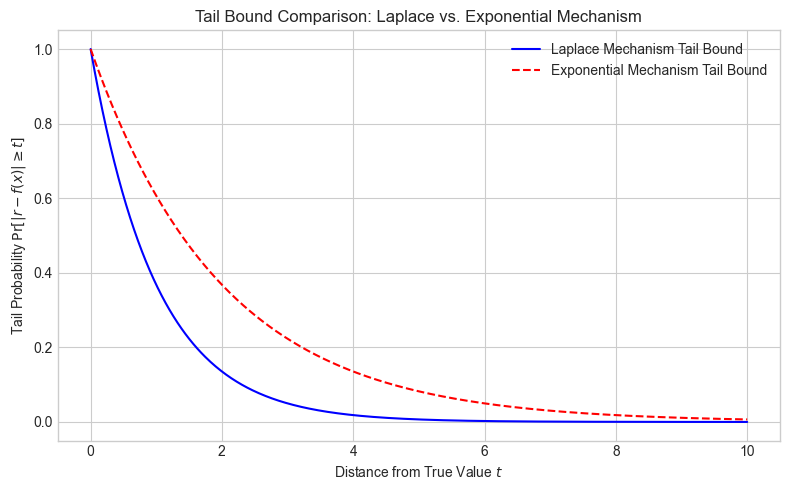

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
epsilon = 1.0
delta_f = 1.0  # Sensitivity
t = np.linspace(0, 10, 500)

# Tail bounds
laplace_tail = np.exp(-epsilon * t / delta_f)
exponential_tail = np.exp(-epsilon * t / (2 * delta_f))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(t, laplace_tail, label='Laplace Mechanism Tail Bound', color='blue')
plt.plot(t, exponential_tail, label='Exponential Mechanism Tail Bound', color='red', linestyle='--')
plt.title('Tail Bound Comparison: Laplace vs. Exponential Mechanism')
plt.xlabel('Distance from True Value $t$')
plt.ylabel('Tail Probability $\\Pr[|r - f(x)| \\geq t]$')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


This code visually demonstrates the **faster decay** of the Laplace mechanism’s tail, and the **constant-factor gap** compared to the Exponential mechanism.

The exponential mechanism is extremely general - it's generally possible to re-define any $\epsilon$-differentially private mechanism in terms of a carefully chosen definition of the scoring function $u$. If we can analyze the sensitivity of this scoring function, then the proof of differential privacy comes for free.

On the other hand, applying the general analysis of the exponential mechanism sometimes comes at the cost of looser bounds (as in the Laplace example above), and mechanisms defined in terms of the exponential mechanism are often very difficult to implement. The exponential mechanism is often used to prove theoretical lower bounds (by showing that a differentially private algorithm *exists*), but practical algorithms often replicate the same behavior using some other approach (as in the case of report noisy max above).


```{admonition} Glossary

- [Exponential Mechanism — Wikipedia](https://en.wikipedia.org/wiki/Differential_privacy#Exponential_mechanism)
- [Utility Function — Wikipedia](https://en.wikipedia.org/wiki/Utility)
- [`numpy.random.choice()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html): Randomly sample from a list, optionally with weights.

```
